# 10.1 다양한 종류의 시계열 작업
- 시계열 데이터는 일정란 간격으로 측정하여 얻은 모든 데이터
- 분류
- 이벤트 감지
- 이상치 탐지 :비지도 학습으로 수행됨
- 푸리에 변환: 주기와 진동이 특징인 데이터를 처리할 때 매우 유용

# 10.2 온도 예측 문제
- 24시간 뒤의 온도를 예측

In [5]:
# 10-1 예나 날씨 데이터 셋 조사하기
import os
fname = os.path.join("jena_climate_2009_2016.csv")   #데이터 합치기

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")    #line의 첫번째 header(칼럼의 이름)를 잡아내고
lines = lines[1:]               # 0은 뺴고 1부터
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
# 10-2 데이터 파싱
# 42만 551개의 데이터 전체를 넘파이 배열로 바꿈
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]   #두번째 열을 'temperature'배열에 저장
    raw_data[i, :] = values[:]   #온도를 포함하여 모든 열을 'raw_data'배열에 저장

In [7]:
# pandas를 이용
import pandas as pd
jena = pd.read_csv("jena_climate_2009_2016.csv")
temperature= jena.loc[:, 'T (degC)'].values
raw_data = jena.iloc[:, 1:].values 

In [8]:
print(temperature[:3])
print(raw_data[:3])

[-8.02 -8.41 -8.51]
[[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
   3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
   1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
 [ 9.96570e+02 -8.41000e+00  2.65010e+02 -9.28000e+00  9.34000e+01
   3.23000e+00  3.02000e+00  2.10000e-01  1.89000e+00  3.03000e+00
   1.30980e+03  7.20000e-01  1.50000e+00  1.36100e+02]
 [ 9.96530e+02 -8.51000e+00  2.64910e+02 -9.31000e+00  9.39000e+01
   3.21000e+00  3.01000e+00  2.00000e-01  1.88000e+00  3.02000e+00
   1.31024e+03  1.90000e-01  6.30000e-01  1.71600e+02]]


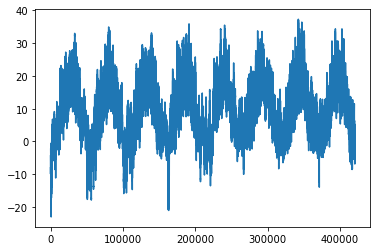

In [9]:
# 10-3 전체 온도를 그래프로 그리기
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

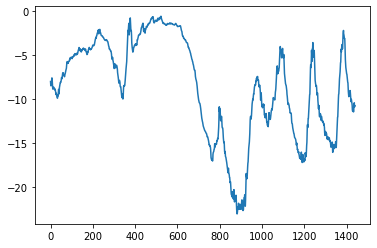

In [10]:
# 10-4 처음 10일간의 온도를 그래프로 그리기
plt.plot(range(1440), temperature[:1440])
plt.show()

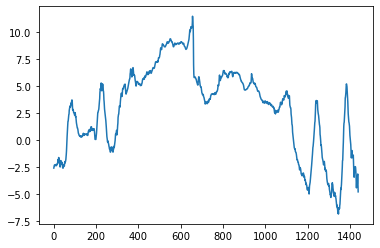

In [11]:
# 최근 10일간 온도를 그래프로 그리기
plt.plot(range(1440), temperature[-1440:])
plt.show()

- 항상 제이터에서 주기성 찾기
- 여러 시간 범위에 걸친 주기성은 시계열 데이터에서 중요, 일반적인 성질
- 데이터를 탐색할 때는 패턴을 찾기
-
- 모든 예제에서 처음 50%의 데이터를 훈련에 사용하고, 다음 25%를 검증, 마지막 25%를 테스트에 상ㅇ
- 미래에서 과거를 예측하는 것이 아니라 과거를 바탕으로 미래를 예측

In [12]:
# 10-5 각 분할에 사용할 샘플 개수 계산하기
# 검증 세트와 테스트 세트 분할
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## 10.2.1 데이터 준비

In [13]:
# 10-6 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
### timeseries_dataset_from_array() 이해하기
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
        
        
# 시계열 데이터 배열을 (data매개변수에) 제공하면 timeseries_dataset_from_array()함수가 원본 시계열에서 추출한 윈도우를 제공 = sequence(시퀀스)
# timeseries_dataset_from_array()함수에 targets 매개변수로 타깃 배열을 전달할 수 있다.
# targets 배열의 첫번째 원소는 data배열에서 생성될 첫번째 시퀀스에 대한 타깃에 해당되어야 함
# 따라서 시계열 예측을 수행한다면 targets는 약간의 시간차를 두고 data배열과 동일 해야 함

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [15]:
# 10-7 훈련, 검증, 테스트 데이터셋 만들기
sampling_rate = 6    #시간당 하나의 데이터 포인터가 샘플링 됨. 즉 6개의 데이터 포인트 중 하나만 사용
sequence_length = 120  #이전 5일간(120시간)데이터를 사용
delay = sampling_rate * (sequence_length + 24 - 1)  # 시퀀스의 타깃은 시퀀스 끝에서 24시간 후의 온도
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [16]:
# 10-8 훈련 데이터셋의 배치크기 확인하기
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
    
# 각 데이터셋은 (samples, targets)크기의 튜플을 반환
# 샘플의 개수: 256개의 타깃온도에 해당하는 배열
# 샘플이 랜덤하게 섞여 있기 때문에 배치에 있는 연속된 두 샘플이 꼭 시간젇으로 가까운 것은 아님

samples shape: (256, 120, 14)
targets shape: (256,)


## 10.2.2 상식 수준의 기준점
- 고전적인 예: 일부 클래스가 월등히 많아 불균형한 분류 작업의  경우
- 데이터 셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면
- 이 분류 문제에 대한 상식 수준 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측 하는 것.

In [17]:
# 10-9 상식 수준 모델의 MAE계산하기
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## 10.2.3 기본적인 머신러닝 모델 시도해보기

- DNN

In [18]:
# 10-10 밀집 연결모델 훈련하고 평가하기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)    # 온도를 예측(회귀)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")   #2.44보다 더 높게 나와야함

Epoch 1/10
819/819 [==============================] - 6s 6ms/step - loss: 13.4081 - mae: 2.8323 - val_loss: 13.2337 - val_mae: 2.8724
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 9.3209 - mae: 2.4033 - val_loss: 10.8962 - val_mae: 2.6092
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 8.6117 - mae: 2.3119 - val_loss: 10.7257 - val_mae: 2.5904
Epoch 4/10
819/819 [==============================] - 6s 7ms/step - loss: 8.1710 - mae: 2.2535 - val_loss: 10.7969 - val_mae: 2.6015
Epoch 5/10
819/819 [==============================] - 7s 8ms/step - loss: 7.8351 - mae: 2.2074 - val_loss: 10.9183 - val_mae: 2.6163
Epoch 6/10
819/819 [==============================] - 7s 8ms/step - loss: 7.5566 - mae: 2.1684 - val_loss: 10.8660 - val_mae: 2.6088
Epoch 7/10
819/819 [==============================] - 6s 7ms/step - loss: 7.3606 - mae: 2.1389 - val_loss: 11.5654 - val_mae: 2.6957
Epoch 8/10
819/819 [==============================] - 6s 8ms/step - 

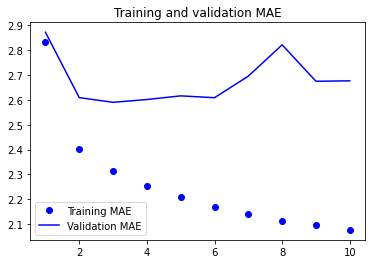

In [19]:
# 10-11 결과 그래프 그리기
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [20]:
## 10.2.4 1D 합성곱 모델 시도해보기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 21.7719 - mae: 3.6774 - val_loss: 17.3789 - val_mae: 3.2807
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 14.8883 - mae: 3.0642 - val_loss: 13.9644 - val_mae: 2.9705
Epoch 3/10
819/819 [==============================] - 20s 24ms/step - loss: 13.4541 - mae: 2.9079 - val_loss: 15.0793 - val_mae: 3.0768
Epoch 4/10
819/819 [==============================] - 20s 24ms/step - loss: 12.5699 - mae: 2.8037 - val_loss: 15.0916 - val_mae: 3.0805
Epoch 5/10
819/819 [==============================] - 19s 24ms/step - loss: 11.9163 - mae: 2.7305 - val_loss: 14.0024 - val_mae: 2.9555
Epoch 6/10
819/819 [==============================] - 20s 25ms/step - loss: 11.4274 - mae: 2.6745 - val_loss: 15.4807 - val_mae: 3.1145
Epoch 7/10
819/819 [==============================] - 20s 24ms/step - loss: 11.0222 - mae: 2.6263 - val_loss: 14.5100 - val_mae: 3.0126
Epoch 8/10
819/819 [============================

- 결과: 2.9도의 검증 MAE를 달성하여 상식 수준의 모델과 차이가 큼
- 2가지 문제
- 날씨 데이터는 평행 이동 불변성 가정을 많이 따르지 않음. 데이터에 일별 주기성이 있지만 아침 데이터는 저녁이나 한밤중의 데이터와 성질이 다름. 날씨 데이터는 매우 특정한 시간 범위에 대해서만 평행불변성을 가짐.
- 이 데이터는 순서가 많이 중요함. 최근 데이터가 5일 전 데이터보다 내일 온도를 예측하는 데 훨씬 거 유용함. 1D 컨브넷은 이런 사실을 활용할 수 없음. 특히 최대 풀링과 전역 풀링 층 때문에 순서 정보가 많이 삭제됨.

## 10.2.5 첫번째 순환 신경망

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 33s 38ms/step - loss: 46.8059 - mae: 5.0012 - val_loss: 15.0238 - val_mae: 2.9261
Epoch 2/10
819/819 [==============================] - 33s 40ms/step - loss: 11.5147 - mae: 2.6266 - val_loss: 9.7869 - val_mae: 2.4336
Epoch 3/10
819/819 [==============================] - 35s 43ms/step - loss: 9.9831 - mae: 2.4641 - val_loss: 9.6742 - val_mae: 2.4122
Epoch 4/10
819/819 [==============================] - 36s 44ms/step - loss: 9.5911 - mae: 2.4185 - val_loss: 9.8329 - val_mae: 2.4089
Epoch 5/10
819/819 [==============================] - 36s 44ms/step - loss: 9.3323 - mae: 2.3852 - val_loss: 9.4766 - val_mae: 2.3712
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 9.0697 - mae: 2.3486 - val_loss: 9.3228 - val_mae: 2.3566
Epoch 7/10
819/819 [==============================] - 37s 46ms/step - loss: 8.7492 - mae: 2.3044 - val_loss: 9.5411 - val_mae: 2.3917
Epoch 8/10
819/819 [==============================] - 38s 4

## 10.3 순환 신경망 이해하기 RNN
- 모든 신경망의 특징은 메모리가 없다는 것
- 네트워크에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없다.
- 이런 네트워크로 시퀀스나 시계열 데이터 포인트를 처리하려면 네트워크 전체 시퀀스를 주입해야 함
- 전체 시퀀스를 하나의 데이터 포인트로 변환해야 함

In [ ]:
# 틀 설명 코드
# 10-13 의사 코드로 표현한 RNN
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# 틀 설명 코드
# 10-14 좀 더 자세한 의사 코드로 표현한 RNN
state = 0
for input_t in input_sequece:
    output_t = activation(dot(W, input_t) + dot(U, state_t)+b)
    state_t = output_t

In [24]:
# 10-15 넘파이로 구현한 간단한 RNN
# RNN의 정방향 계간을 넘파이로 구현
import numpy as np
timesteps = 100   #입력 시퀀스에 있는 타입스텝의 수
input_features = 32   #입력 특성의 차원
output_features = 64   # 출력 특성의 차원
inputs = np.random.random((timesteps, input_features))   # 입력 데이터: 예제를 위한 랜덤한 잡음
state_t = np.zeros((output_features,))     # 초기상태: 0벡터
W = np.random.random((output_features, input_features))    # 랜덤 가중치 행렬을 만듦
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:                                    #input_t 는 (input_features,)크기의 벡터
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # 출력을 리스트에 저장
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [25]:
# output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t)+b)

- 시간에 따라 펼쳐진 간단한 RNN
출력 t-1                    출력t                       출력+1
        
             상태          output_t          상태t+1

입력 t-1                     입력t                      입력 t+1



output = activation(Wo * input_t + Uo * state_t + bo)

## 10.3.1 케라스의 순환 층
- timesteps, input_features 크기가 아니라 batch_size, timesteps, input_features 크기의 입력을 받음
- 시작할 때 input()함수의 shape 매개변수에 timesteps 항목을 None으로 지정할 수 있다. => 임의이 길이를 가진 시퀀스를 처리할 수 있다.

In [26]:
# 10-16 어떤 실이의 시퀀스도 처리할 수 있는 RNN층
num_features =14
inputs = keras.Input(shape =(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

- 케라스에 있는 모든 순환층(SimpleRNN, LSTM, GRU)은 두가지 모드로 실행할 수 있다.
- 각 타임스텝의 출력을 모은 전체 시퀀스((batch_size, timesteps, output_features))크기의 랭크-3 텐서을 반환하거나
- 입력 시퀀스의 마지막 출력((batch_size, output_features))크기의 랭크-2 텐서만 반환할 수 있다.
- 두 모드는 생성자의 return_sequences 매개변수로 제어할 수 있다.

In [27]:
# 10-7 마지막 출력 스텝만 반환하는 RNN층
num_features =14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [28]:
# 10-18 전체 출력 시퀀스를 반환하는 RNN층
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [29]:
# 네트워크의 표현을 증가시키기 위해 여러개의 순환층을 차례로 쌓는 것이 유용할 때가 있음
# 중간층들이 전체 출력 시퀀스를 반환하도록 설정 해야 함

In [30]:
# 10-19 스태킹(stacking)RNN층
# 레이어를 여러개 쌓음
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [31]:
# 시퀀스의 어느 지점에서 추출된 정보가 컨베이어 벨트 위로 올라가 필요한 시점의 타임스텝으로 이동하여 떨굼
# => LSTM이 하는 일

- LSTM층의 시작점: SimpleRNN
출력 t-1                    출력t                       출력+1
        
             상태          output_t          상태t+1

입력 t-1                     입력t                      입력 t+1



output = activation(Wo * input_t + Uo * state_t + bo)

- SimpleRNN에서 LSTM으로: 이동 트랙 추가
          출력 t-1                    출력t                       출력+1
ct-1                    ct                           ct+1                      이동트랙
                          ct 
                                                          ct+1         
                       상태t          output_t          상태t+1

          
          입력 t-1                     입력t                      입력 t+1



output = activation(Wo * input_t + Uo * state_t + bo)

In [35]:
# y = activation(dot(state_t, U)+dot(input_t, W)+b)

In [ ]:
# 10-20 LSTM 구조의 의사 코드 (1/2)
outputs = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) +bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

In [ ]:
# 10-21 LSTM 구조의 의사 코드(2/2)
c_t+1 = i_t * k_t + c_t * f_t
#c_t+1 = 입력게이트 + 삭제게이트

### LSTM의 역할
- 과거 정보를 나중에 다시 주입하여 그레이디언트 소실 문제를 해결

# 10.4 순환 신경망의 고급 사용법
- 순환 드롭아웃: 드롭아웃의 한 종류로 순환 층에서 과대적합을 방지하기 위해 사용
- 스태킹 순환 층: 모델의 표현능력을 증가시킴(비용이 많이 든다)
- 양방향 순환층: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지

## 10.4.1 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
- 훈련손실과 검증손실 곡선을 보면 모델이 과대적합인지 알 수 있다.
- 동일한 패턴으로 유닛을 드롭아웃 한다
- GRU, LSTM같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환층 내부 계산에 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 함

In [38]:
# 10-22 드롭아웃 규제를 적용한 LSTM모델 훈련하고 평가하기

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)   # Dense층에 규제를 추가하기 위해 LSTM층 뒤에도 Dropout층을 추가
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks) 

Epoch 1/50
819/819 [==============================] - 85s 101ms/step - loss: 25.9344 - mae: 3.7755 - val_loss: 9.9285 - val_mae: 2.4442
Epoch 2/50
819/819 [==============================] - 88s 107ms/step - loss: 14.5413 - mae: 2.9571 - val_loss: 9.6859 - val_mae: 2.4085
Epoch 3/50
819/819 [==============================] - 88s 107ms/step - loss: 13.7444 - mae: 2.8738 - val_loss: 9.2991 - val_mae: 2.3606
Epoch 4/50
819/819 [==============================] - 89s 108ms/step - loss: 13.2523 - mae: 2.8199 - val_loss: 9.1522 - val_mae: 2.3519
Epoch 5/50
819/819 [==============================] - 88s 108ms/step - loss: 12.6197 - mae: 2.7492 - val_loss: 9.3695 - val_mae: 2.3841
Epoch 6/50
819/819 [==============================] - 88s 108ms/step - loss: 12.2101 - mae: 2.7023 - val_loss: 9.3260 - val_mae: 2.3625
Epoch 7/50
819/819 [==============================] - 89s 108ms/step - loss: 11.8636 - mae: 2.6596 - val_loss: 9.5286 - val_mae: 2.3973
Epoch 8/50
819/819 [============================

# 10.4.2 스태킹 순환층
- 과대적합은 더이상 없지만 성능상 병목이 있는 것 같으므로 네트워크의 용량과 표현력을 늘려야 함
- 과대적랍이 일어날 때 까지 모델의 용량을 늘리는 것이 좋다.
- 네트워크 용량을 늘리려면 일반적으로 층에 있는 유닛의 개수를 늘리거나 층을 더 많이 추가
- return_sequences=True로 지정하면 모든 중간층은 마지막 타임스텝 출력만 아니고 전체 스퀀스를 출력

In [ ]:
# 10-23 듣롭아웃 규제와 스태킹을 적용한 GRU모델을 훈련하고 평가하기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 266s 320ms/step - loss: 27.4268 - mae: 3.8416 - val_loss: 9.6192 - val_mae: 2.3927
Epoch 2/50
819/819 [==============================] - 268s 327ms/step - loss: 14.0849 - mae: 2.9078 - val_loss: 9.1244 - val_mae: 2.3332
Epoch 3/50
819/819 [==============================] - 273s 334ms/step - loss: 13.3291 - mae: 2.8315 - val_loss: 8.9894 - val_mae: 2.3135
Epoch 4/50
819/819 [==============================] - 274s 335ms/step - loss: 12.7315 - mae: 2.7667 - val_loss: 9.2133 - val_mae: 2.3419
Epoch 5/50
819/819 [==============================] - 284s 346ms/step - loss: 12.3671 - mae: 2.7289 - val_loss: 8.8084 - val_mae: 2.2879
Epoch 6/50
819/819 [==============================] - 277s 339ms/step - loss: 11.9440 - mae: 2.6821 - val_loss: 9.1092 - val_mae: 2.3321
Epoch 7/50
819/819 [==============================] - 286s 349ms/step - loss: 11.5993 - mae: 2.6398 - val_loss: 9.2021 - val_mae: 2.3488
Epoch 8/50
819/819 [=====================

In [ ]:
# 10.4.3 양방향 RNN사용하기
- RNN의 한 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냄
- 입력 시퀀스의 타임스텝 순서대로 처리함
- 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꿈
- 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있다.
- 해야 할 일: 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는  데이터 제너레이터를 만드는 것(제너레이터 함수의 마지막 줄을 yield samples[:, ::-1, :], targets로 바꾼다.)

In [ ]:
- LSTM기반의 모델을 훈련
- 순서를 뒤집은 LSTM은 상식 수준의 기준점보다도 성능이 낮음
- 이 경우에는 시간 순서대로 처리 하는 것이 중요한 역할을 함
- 최근에 가까운 날씨 데이터 포인트일 수록 오래된 데이터 포인트보다 예측에 유용하다(상식 수준의 기준점이 꽤 강력한 이유임)
- 따라서 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 한다.

In [ ]:
- 자연어 처리
- 문장을 이해하는 데 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않음
- 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동됨

In [ ]:
- 거꾸로된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습 함
- 머신러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있다.
- 표현이 많이 다를수록 좋다.

In [ ]:
- 양방향 RNN은 시간 순서대로 처리하는 RNN의 성능을 향상시킴
- 입력 시퀀스를 양쪽 방향으로 바라보기 때문에 잠재적으로 풍부한 표현을 얻고 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 감지할 수 있음

In [ ]:
- 케라스에서는 Bidirectional 층을 사용하여 양방향 RNN을 만듭니다.
- 이 클래스는 첫번째 매개변수로 순환 층의 객체를 전달 받는다.
- Bidrectional 클래스는 전달 받은 순환 층으로 새로운 두번째 객체를 만든다.
- 하나는 시간 순서대로 입력 시퀀스를 처리하고
- 다른 하나는 반대 순서로 입력 시퀀스를 처리 함.

In [ ]:
# 10-24
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)